# HERON Tutorial: CTDE Training + Event-Driven Testing

This notebook demonstrates how to build a multi-agent reinforcement learning system using HERON framework with:

1. **CTDE Training (Mode A)**: Centralized Training with Decentralized Execution
2. **Event-Driven Testing (Mode B)**: Realistic asynchronous simulation

## What is CTDE?

**Centralized Training, Decentralized Execution** is a paradigm where:
- **Training**: A centralized controller has access to all agents' observations and can coordinate learning
- **Execution**: Each agent acts independently using only its local observations

## Why Event-Driven Testing?

In real-world deployments, agents don't act synchronously. They have:
- Different tick rates (sensors sample faster than controllers)
- Communication delays (network latency)
- Observation delays (sensor processing time)
- Action delays (actuator response time)

Event-driven testing validates that policies trained in idealized synchronous settings still work under realistic timing constraints.

## Setup

First, let's import the necessary modules from HERON.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Optional, Tuple

import gymnasium as gym
from gymnasium.spaces import Box, Dict as DictSpace

# HERON imports
from heron.agents.field_agent import FieldAgent, FIELD_LEVEL
from heron.agents.coordinator_agent import CoordinatorAgent, COORDINATOR_LEVEL
from heron.agents.system_agent import SystemAgent, SYSTEM_LEVEL
from heron.core.observation import Observation
from heron.core.feature import FeatureProvider
from heron.core.action import Action
from heron.core.policies import Policy
from heron.envs.base import MultiAgentEnv
from heron.scheduling import EventScheduler, EventType, TickConfig, JitterType

print("HERON modules loaded successfully!")

HERON modules loaded successfully!


---
## Data & Execution Flow

### HERON Agent Lifecycle

| Method | What it does |
|--------|--------------|
| `observe()` | Returns `Observation` with local state |
| `act(obs, upstream_action)` | Stores action in `self.action` |
| `update_from_environment(state)` | Updates agent state after physics |
| `reset()` | Resets agent to initial state |
| `tick(scheduler, time, ...)` | Event-driven execution |

### HERON Hooks (Override in Subclasses)

| Hook | Purpose |
|------|---------|
| `set_state()` | Define your state features |
| `set_action()` | Define your action space |
| `reset_agent()` | Custom reset logic |
| `update_state(**kwargs)` | Handle state updates |
| `_build_subordinates()` | Create subordinate agents |

### Agent Hierarchy

```
EnergyManagementEnv
        │
        ▼ calls L3 only
GridSystemAgent (L3)
        │
        ▼ calls L2 only
ZoneCoordinator (L2)
        │
        ▼ calls L1 only
BatteryAgent (L1) ← Each agent manages its OWN state

Env → L3 → L2 → L1  (never skip levels!)
```

### Simulation Step (Synchronous Mode - Training)

```
env.step(actions)
│
├─► 1. APPLY ACTIONS:  L3.apply_field_actions() → L2 → L1.act()
│
├─► 2. PHYSICS:        L3.simulate_physics() → L2 → L1.simulate_physics()
│                      (each agent computes its OWN new state)
│
├─► 3. UPDATE:         L3.update_field_agents() → L2 → L1.update_from_environment()
│
├─► 4. OBSERVE:        L3.collect_field_observations() → L2 → L1.get_observation()
│                      (each agent builds its OWN observation)
│
└─► 5. REWARD:         L3.get_field_rewards() → L2 → L1.get_reward()
                       (each agent computes its OWN reward)
```

### Simulation Step (Event-Driven Mode - Testing)

```
EventScheduler.run_until(t_end)
│
├─► SETUP: field_agent_ids = L3.get_field_agent_ids()  (via L2)
│          scheduler.register_agent(aid, tick_config)
│
└─► AGENT_TICK Handler:
    ├─► 1. obs = L3.collect_field_observations(price)[aid]
    ├─► 2. action = policy.forward_deterministic(obs)
    ├─► 3. L3.apply_field_actions({aid: action})
    ├─► 4. results = L3.simulate_physics()
    └─► 5. L3.update_field_agents({aid: results[aid]})
```

### Learning (Policy Gradient with Critic Baseline)

```
For each agent independently:
1. Collect trajectory: [(o₀,a₀,r₀), (o₁,a₁,r₁), ...]
2. Compute returns:    Gₜ = rₜ + γ·rₜ₊₁ + γ²·rₜ₊₂ + ...
3. Compute advantage:  Aₜ = Gₜ - V(oₜ)
4. Update actor:       ∇θ J ≈ Aₜ · ∇θ log π(aₜ|oₜ)
5. Update critic:      Minimize (V(oₜ) - Gₜ)²
```

### Training vs Event-Driven Testing

| Aspect | Training (Mode A) | Testing (Mode B) |
|--------|-------------------|------------------|
| Timing | Synchronous | Async + jitter |
| Flow | `env.step()` → L3 → L2 → L1 | `EventScheduler` → L3 → L2 → L1 |
| Obs/Action | Instant | Configurable delay |
| Policy | Stochastic | Deterministic |

### Key Design Principles

1. **Strict Hierarchy**: Env → L3 → L2 → L1 (never skip levels)
2. **Self-Management**: Each agent manages its OWN state, observations, rewards
3. **Delegation**: Upper levels delegate, they don't compute lower levels' state
4. **Flat MARL Interface**: L3 provides flat `{agent_id: value}` while maintaining hierarchy

---
## Part 1: Building the Agent Hierarchy

HERON uses a 3-level hierarchy:

```
Level 3: SystemAgent (Grid Operator)
    │
    ├── Level 2: CoordinatorAgent (Zone A)
    │       ├── Level 1: FieldAgent (Battery A1)
    │       └── Level 1: FieldAgent (Battery A2)
    │
    └── Level 2: CoordinatorAgent (Zone B)
            └── Level 1: FieldAgent (Battery B1)
```

Each level has different responsibilities and tick rates.

### 1.1 Feature Provider

**FeatureProviders** define observable state attributes with **visibility rules**.

For this demo, we use a single feature to track battery state of charge (SOC).

In [2]:
class BatteryChargeFeature(FeatureProvider):
    """Battery state of charge feature."""
    visibility = ["public"]

    def __init__(self, soc: float = 0.5, capacity: float = 100.0):
        self.soc = soc
        self.capacity = capacity

    def vector(self) -> np.ndarray:
        return np.array([self.soc, self.capacity], dtype=np.float32)

    def names(self) -> List[str]:
        return ["soc", "capacity"]

    def to_dict(self) -> Dict[str, Any]:
        return {"soc": self.soc, "capacity": self.capacity}

    @classmethod
    def from_dict(cls, d: Dict[str, Any]) -> "BatteryChargeFeature":
        return cls(soc=d.get("soc", 0.5), capacity=d.get("capacity", 100.0))

    def set_values(self, **kwargs) -> None:
        if "soc" in kwargs:
            self.soc = np.clip(kwargs["soc"], 0.0, 1.0)
        if "capacity" in kwargs:
            self.capacity = kwargs["capacity"]


print("BatteryChargeFeature defined - tracks SOC and capacity")

BatteryChargeFeature defined - tracks SOC and capacity


### 1.2 Field Agent (Level 1)

**FieldAgents** are the lowest level - individual devices that interact with the physical world.

**HERON provides** (via FieldAgent base class):
- `observe()` → returns `Observation` with local state
- `act(observation, upstream_action)` → stores action in `self.action`
- `update_from_environment(state)` → receives state updates from environment
- `set_state()` / `set_action()` / `reset_agent()` → initialization hooks
- `tick()` → for event-driven mode (calls observe + act internally)

**You override:**
- `set_state()` → define your state features
- `set_action()` → define your action space
- `update_state()` → handle state updates (optional hook)

In [3]:
class BatteryAgent(FieldAgent):
    """Battery field agent - Level 1 in the hierarchy.
    
    Uses HERON's standard lifecycle:
        1. observe() → get current state as Observation
        2. act(obs, upstream_action) → store action in self.action
        3. simulate_physics() → compute new state from action (L1 owns this!)
        4. update_from_environment(state) → receive new SOC
    
    Each agent manages its OWN state - L2 doesn't compute L1's state.
    """

    def __init__(self, agent_id: str, capacity: float = 100.0, initial_soc: float = 0.5, **kwargs):
        self._capacity = capacity
        self._initial_soc = initial_soc
        super().__init__(agent_id=agent_id, **kwargs)

    @property
    def soc(self) -> float:
        return self.state.features[0].soc

    @property
    def capacity(self) -> float:
        return self.state.features[0].capacity

    # ---- HERON hooks (override base class) ----
    
    def set_action(self) -> None:
        """Define action space: charge/discharge rate in [-1, 1]."""
        self.action.set_specs(dim_c=1, range=(np.array([-1.0]), np.array([1.0])))

    def set_state(self) -> None:
        """Define state: battery SOC and capacity."""
        self.state.features = [BatteryChargeFeature(soc=self._initial_soc, capacity=self._capacity)]

    def _get_obs(self, proxy=None) -> np.ndarray:
        """Build observation vector from state features."""
        return self.state.vector()

    def reset_agent(self, **kwargs) -> None:
        """Reset battery to initial SOC."""
        self.state.features[0].set_values(soc=self._initial_soc)

    def update_state(self, **kwargs) -> None:
        """Handle state updates from environment (HERON hook).
        
        Called by update_from_environment() after physics simulation.
        """
        if "soc" in kwargs:
            self.state.features[0].set_values(soc=kwargs["soc"])

    # ---- L1 Physics (each agent manages its OWN state) ----
    
    def simulate_physics(self) -> Dict[str, Any]:
        """Compute new state based on current action.
        
        L1 owns its own physics! L2 doesn't compute L1's state.
        
        Returns:
            Dict with new state values (to be applied via update_from_environment)
        """
        action_value = float(self.action.c[0]) if self.action.c is not None else 0.0
        new_soc = np.clip(self.soc + action_value * 0.02, 0.0, 1.0)
        return {"soc": new_soc}
    
    def get_reward(self) -> float:
        """Compute reward for this agent (reward = SOC).
        
        L1 owns its own reward computation.
        """
        return self.soc
    
    def get_observation(self, price: float) -> np.ndarray:
        """Get normalized observation vector.
        
        L1 owns its own observation format.
        
        Args:
            price: Current energy price (passed from environment via hierarchy)
        """
        return np.array([self.soc, self.capacity / 100.0, price], dtype=np.float32)


# Test HERON lifecycle
test_battery = BatteryAgent("test_battery", capacity=100.0)
print(f"BatteryAgent: Level {test_battery.level}, SOC={test_battery.soc:.0%}")

# 1. Set action (simulating act() being called)
test_battery.action.set_values(np.array([1.0]))
print(f"  Action set: {test_battery.action.c[0]:.1f}")

# 2. L1 computes its OWN new state
physics_result = test_battery.simulate_physics()
print(f"  L1 simulate_physics(): {physics_result}")

# 3. Apply the result via HERON method
test_battery.update_from_environment(physics_result)
print(f"  After update_from_environment: SOC={test_battery.soc:.1%}")

BatteryAgent: Level 1, SOC=50%
  Action set: 1.0
  L1 simulate_physics(): {'soc': 0.52}
  After update_from_environment: SOC=52.0%


### 1.3 Coordinator Agent (Level 2)

**CoordinatorAgents** manage groups of field agents within a zone.

**HERON provides** (via CoordinatorAgent base class):
- `observe()` → aggregates observations from all subordinates
- `act()` / `coordinate_subordinates()` → distributes actions to subordinates
- `_build_subordinates()` → abstract method you must implement
- `get_joint_action_space()` → returns combined action space

**You override:**
- `_build_subordinates()` → create your field agent instances

In [4]:
class ZoneCoordinator(CoordinatorAgent):
    """Zone coordinator - Level 2. Manages BatteryAgents within a zone.
    
    Uses HERON's standard lifecycle:
        - observe() → aggregates subordinate observations (inherited)
        - act() → distributes actions to subordinates (inherited)
        - _build_subordinates() → creates BatteryAgent instances (override)
    
    L2 Interface Methods (delegates to L1 - never computes L1's state!):
        - get_field_agent_ids() → returns IDs of subordinate field agents
        - apply_field_actions() → calls L1.act()
        - simulate_physics() → calls L1.simulate_physics()
        - update_field_agents() → calls L1.update_from_environment()
        - collect_field_observations() → calls L1.get_observation()
        - get_field_rewards() → calls L1.get_reward()
    """

    def _build_subordinates(self, agent_configs: List[Dict], **kwargs) -> Dict[str, BatteryAgent]:
        """Build BatteryAgent subordinates from configuration (HERON hook)."""
        return {
            cfg["id"]: BatteryAgent(cfg["id"], cfg.get("capacity", 100.0), cfg.get("initial_soc", 0.5), **kwargs)
            for cfg in agent_configs
        }

    # ---- L2 Interface Methods (delegates to L1) ----
    
    def get_field_agent_ids(self) -> List[str]:
        """Get IDs of all field agents managed by this coordinator."""
        return list(self.subordinates.keys())
    
    def apply_field_actions(self, actions: Dict[str, Any]) -> None:
        """Apply actions by calling L1.act().
        
        Args:
            actions: Dict mapping field agent IDs to actions
        """
        for aid, agent in self.subordinates.items():
            if aid in actions:
                obs = agent.observe()
                agent.act(obs, upstream_action=actions[aid])
    
    def simulate_physics(self) -> Dict[str, Dict[str, Any]]:
        """Run physics by calling L1.simulate_physics().
        
        L2 delegates to L1 - each agent computes its OWN state.
        
        Returns:
            Dict mapping field agent IDs to physics results
        """
        results = {}
        for aid, agent in self.subordinates.items():
            results[aid] = agent.simulate_physics()  # L1 computes its own state!
        return results
    
    def update_field_agents(self, physics_results: Dict[str, Dict[str, Any]]) -> None:
        """Update agents by calling L1.update_from_environment().
        
        Args:
            physics_results: Dict mapping field agent IDs to state updates
        """
        for aid, agent in self.subordinates.items():
            if aid in physics_results:
                agent.update_from_environment(physics_results[aid])
    
    def collect_field_observations(self, price: float) -> Dict[str, np.ndarray]:
        """Collect observations by calling L1.get_observation().
        
        Args:
            price: Current energy price to pass to field agents
            
        Returns:
            Dict mapping field agent IDs to observation vectors
        """
        obs = {}
        for aid, agent in self.subordinates.items():
            obs[aid] = agent.get_observation(price)  # L1 builds its own observation!
        return obs
    
    def get_field_rewards(self) -> Dict[str, float]:
        """Get rewards by calling L1.get_reward().
        
        Returns:
            Dict mapping field agent IDs to rewards
        """
        return {aid: agent.get_reward() for aid, agent in self.subordinates.items()}


# Test
test_coord = ZoneCoordinator("zone_a", config={"agents": [{"id": "bat1"}, {"id": "bat2"}]})
print(f"ZoneCoordinator: Level {test_coord.level}")
print(f"  Subordinates: {list(test_coord.subordinates.keys())}")
print(f"  L2 delegates to L1: simulate_physics() calls agent.simulate_physics()")

ZoneCoordinator: Level 2
  Subordinates: ['bat1', 'bat2']
  L2 delegates to L1: simulate_physics() calls agent.simulate_physics()


### 1.4 System Agent (Level 3)

**SystemAgent** is the top level - the only interface between environment and agent hierarchy.

**HERON provides** (via SystemAgent base class):
- `observe()` → aggregates observations from all coordinators
- `act()` / `coordinate_subordinates()` → distributes actions to coordinators
- `_build_subordinates()` → abstract method you must implement
- `reset()` → resets entire hierarchy
- `update_from_environment()` / `get_state_for_environment()` → env interface

**You override:**
- `_build_subordinates()` → create your coordinator instances

In [5]:
class GridSystemAgent(SystemAgent):
    """Grid system agent - Level 3. Only interface between environment and hierarchy.
    
    **Proper Hierarchy**: L3 only calls L2 methods, never accesses L1 directly.
    
    Uses HERON's standard lifecycle:
        - observe() → aggregates coordinator observations (inherited)
        - act() → distributes actions to coordinators (inherited)
        - _build_subordinates() → creates ZoneCoordinator instances (override)
    
    L3 Interface Methods (for Environment to call):
        - get_field_agent_ids() → calls L2.get_field_agent_ids()
        - apply_field_actions() → calls L2.apply_field_actions()
        - simulate_physics() → calls L2.simulate_physics()
        - update_field_agents() → calls L2.update_field_agents()
        - collect_field_observations() → calls L2.collect_field_observations()
        - get_field_rewards() → calls L2.get_field_rewards()
    """

    def _build_subordinates(self, coordinator_configs: List[Dict], **kwargs) -> Dict[str, ZoneCoordinator]:
        """Build ZoneCoordinator subordinates from configuration (HERON hook)."""
        return {
            cfg["id"]: ZoneCoordinator(cfg["id"], config={"agents": cfg.get("agents", [])}, **kwargs)
            for cfg in coordinator_configs
        }

    # ---- L3 Interface Methods (delegates to L2 coordinators) ----
    
    def get_field_agent_ids(self) -> List[str]:
        """Get all field agent IDs by asking coordinators (L3 → L2)."""
        ids = []
        for coord in self.subordinates.values():
            ids.extend(coord.get_field_agent_ids())
        return ids
    
    def apply_field_actions(self, actions: Dict[str, Any]) -> None:
        """Apply actions by delegating to coordinators (L3 → L2 → L1).
        
        Args:
            actions: Dict mapping field agent IDs to actions
        """
        for coord in self.subordinates.values():
            coord.apply_field_actions(actions)
    
    def simulate_physics(self) -> Dict[str, Dict[str, Any]]:
        """Run physics by delegating to coordinators (L3 → L2 → L1).
        
        Returns:
            Dict mapping field agent IDs to physics results
        """
        results = {}
        for coord in self.subordinates.values():
            results.update(coord.simulate_physics())
        return results
    
    def update_field_agents(self, physics_results: Dict[str, Dict[str, Any]]) -> None:
        """Update agents by delegating to coordinators (L3 → L2 → L1).
        
        Args:
            physics_results: Dict mapping field agent IDs to state updates
        """
        for coord in self.subordinates.values():
            coord.update_field_agents(physics_results)
    
    def collect_field_observations(self, price: float) -> Dict[str, np.ndarray]:
        """Collect observations by delegating to coordinators (L3 → L2 → L1).
        
        Args:
            price: Current energy price to include in observations
            
        Returns:
            Dict mapping field agent IDs to observation vectors
        """
        obs = {}
        for coord in self.subordinates.values():
            obs.update(coord.collect_field_observations(price))
        return obs
    
    def get_field_rewards(self) -> Dict[str, float]:
        """Get rewards by delegating to coordinators (L3 → L2 → L1).
        
        Returns:
            Dict mapping field agent IDs to rewards
        """
        rewards = {}
        for coord in self.subordinates.values():
            rewards.update(coord.get_field_rewards())
        return rewards


# Test
test_config = {
    "coordinators": [
        {"id": "zone_a", "agents": [{"id": "bat1"}, {"id": "bat2"}]},
        {"id": "zone_b", "agents": [{"id": "bat3"}]}
    ]
}
test_system = GridSystemAgent("grid_system", config=test_config)
print(f"GridSystemAgent: Level {test_system.level}")
print(f"  Coordinators (L2): {list(test_system.subordinates.keys())}")
print(f"  Field agents (via L2): {test_system.get_field_agent_ids()}")
print(f"  Hierarchy: L3 → L2 → L1 (never L3 → L1 directly)")

GridSystemAgent: Level 3
  Coordinators (L2): ['zone_a', 'zone_b']
  Field agents (via L2): ['bat1', 'bat2', 'bat3']
  Hierarchy: L3 → L2 → L1 (never L3 → L1 directly)


---
## Part 2: Environment

The environment uses HERON's `MultiAgentEnv` base class which provides:
- `register_agent()` → register agents with environment
- `get_observations()` → collect observations from all agents
- `apply_actions()` → apply actions to agents
- `setup_event_driven()` / `run_event_driven()` → event-driven execution

The environment handles **physics simulation** (domain-specific) and uses HERON's agent lifecycle methods.

In [6]:
class EnergyManagementEnv(MultiAgentEnv):
    """Multi-agent environment using HERON patterns.
    
    **Encapsulation**: Environment ONLY interacts with GridSystemAgent (L3).
    All field agent access is routed through the SystemAgent's interface methods.
    
    HERON lifecycle in step():
        1. grid_system.apply_field_actions() → routes actions through hierarchy
        2. grid_system.simulate_physics() → domain-specific simulation
        3. grid_system.update_field_agents() → updates agents via hierarchy
        4. grid_system.collect_field_observations() → collects obs via hierarchy
        5. grid_system.get_field_rewards() → computes rewards via hierarchy
    """

    def __init__(self, config: Optional[Dict] = None, max_steps: int = 100, **kwargs):
        super().__init__(**kwargs)
        
        config = config or {
            "coordinators": [
                {"id": "zone_a", "agents": [{"id": "battery_a1"}, {"id": "battery_a2"}]},
                {"id": "zone_b", "agents": [{"id": "battery_b1"}]}
            ]
        }
        
        self._max_steps = max_steps
        self._timestep = 0
        self._price = 0.10
        
        # Build agent hierarchy - this is the ONLY agent reference env keeps
        self._grid_system = GridSystemAgent("grid_system", config=config, env_id=self.env_id)
        
        # Register with HERON's registry (for event-driven mode)
        self.register_agent(self._grid_system)
        for coord in self._grid_system.subordinates.values():
            self.register_agent(coord)
            for agent in coord.subordinates.values():
                self.register_agent(agent)

    @property
    def grid_system(self) -> GridSystemAgent:
        """The SystemAgent - only interface to agent hierarchy."""
        return self._grid_system

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            np.random.seed(seed)
        self._timestep = 0
        self._price = 0.10
        
        # Reset via SystemAgent (resets entire hierarchy)
        self._grid_system.reset(seed=seed)
        
        # Collect observations via SystemAgent
        return self._grid_system.collect_field_observations(self._price), {}

    def step(self, actions):
        """Execute one step - all access through SystemAgent only.
        
        Args:
            actions: Dict mapping field agent IDs to action arrays
        """
        self._timestep += 1
        self._price = 0.10 + 0.05 * np.sin(2 * np.pi * self._timestep / 24)
        
        # 1. Apply actions through SystemAgent (routes to field agents via hierarchy)
        self._grid_system.apply_field_actions(actions)
        
        # 2. Run physics simulation through SystemAgent
        physics_results = self._grid_system.simulate_physics()
        
        # 3. Update agents through SystemAgent (routes to field agents via hierarchy)
        self._grid_system.update_field_agents(physics_results)
        
        # 4. Collect observations through SystemAgent
        obs = self._grid_system.collect_field_observations(self._price)
        
        # 5. Get rewards through SystemAgent
        rewards = self._grid_system.get_field_rewards()
        
        terminated = {"__all__": self._timestep >= self._max_steps}
        
        return obs, rewards, terminated, {"__all__": False}, {"physics": physics_results, "price": self._price}

    def get_joint_observation_space(self):
        return DictSpace({
            aid: Box(-np.inf, np.inf, (3,))
            for aid in self._grid_system.get_field_agent_ids()
        })

    def get_joint_action_space(self):
        return DictSpace({
            aid: Box(-1.0, 1.0, (1,), np.float32)
            for aid in self._grid_system.get_field_agent_ids()
        })


# Test
env = EnergyManagementEnv(max_steps=100)
print(f"Environment created")
print(f"  Field agents (via SystemAgent): {env.grid_system.get_field_agent_ids()}")
print(f"  Encapsulation: env only calls grid_system methods, never field agents directly")

Environment created
  Field agents (via SystemAgent): ['battery_a1', 'battery_a2', 'battery_b1']
  Encapsulation: env only calls grid_system methods, never field agents directly


---
## Part 3: CTDE Training (Mode A)

In CTDE training:
1. All agents step **synchronously**
2. A **centralized trainer** sees all observations
3. Policies are updated using **joint information**
4. At deployment, each agent uses only **local observations**

In [7]:
# Neural Policy for CTDE Demo

class SimpleMLP:
    """Simple MLP for value function approximation."""
    def __init__(self, input_dim, hidden_dim, output_dim, seed=42):
        np.random.seed(seed)
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2.0 / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, output_dim) * np.sqrt(2.0 / hidden_dim)
        self.b2 = np.zeros(output_dim)

    def forward(self, x):
        h = np.maximum(0, x @ self.W1 + self.b1)
        return np.tanh(h @ self.W2 + self.b2)

    def update(self, x, target, lr=0.01):
        h = np.maximum(0, x @ self.W1 + self.b1)
        out = np.tanh(h @ self.W2 + self.b2)
        d_out = (out - target) * (1 - out**2)
        self.W2 -= lr * np.outer(h, d_out)
        self.b2 -= lr * d_out
        d_h = d_out @ self.W2.T
        d_h[h <= 0] = 0
        self.W1 -= lr * np.outer(x, d_h)
        self.b1 -= lr * d_h


class NeuralPolicy(Policy):
    """Neural network policy for battery control.
    
    Uses a simple 2-layer MLP to map observations to actions.
    Trained using policy gradient with advantage estimation.
    
    Architecture:
        obs (3D) -> hidden (32) -> action (1D, tanh activation)
    
    The policy learns to maximize SOC by outputting positive actions (charge).
    """
    def __init__(self, obs_dim, action_dim=1, hidden_dim=32, seed=42):
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.hidden_dim = hidden_dim
        np.random.seed(seed)
        
        # Actor network - initialized with small weights
        self.W1 = np.random.randn(obs_dim, hidden_dim) * np.sqrt(2.0 / obs_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, action_dim) * 0.1
        self.b2 = np.zeros(action_dim)
        
        # Critic network for value estimation
        self.critic = SimpleMLP(obs_dim, hidden_dim, 1, seed + 1)
        
        # Exploration noise (decreases over training)
        self.noise_scale = 0.3

    def forward(self, observation):
        """Compute action from observation."""
        obs_vec = observation.vector()
        
        # Forward pass through actor network
        h = np.maximum(0, obs_vec @ self.W1 + self.b1)  # ReLU
        action_mean = np.tanh(h @ self.W2 + self.b2)    # tanh for [-1, 1]
        
        # Add exploration noise during training
        action_vec = action_mean + np.random.normal(0, self.noise_scale, self.action_dim)
        action_vec = np.clip(action_vec, -1.0, 1.0)
        
        action = Action()
        action.set_specs(dim_c=self.action_dim, range=(np.full(self.action_dim, -1.0), np.full(self.action_dim, 1.0)))
        action.set_values(action_vec)
        return action
    
    def forward_deterministic(self, observation):
        """Compute action without exploration noise (for evaluation)."""
        obs_vec = observation.vector()
        h = np.maximum(0, obs_vec @ self.W1 + self.b1)
        action_vec = np.tanh(h @ self.W2 + self.b2)
        
        action = Action()
        action.set_specs(dim_c=self.action_dim, range=(np.full(self.action_dim, -1.0), np.full(self.action_dim, 1.0)))
        action.set_values(action_vec)
        return action

    def get_value(self, observation):
        """Estimate value of current state."""
        return float(self.critic.forward(observation.vector())[0])

    def update(self, obs, action_taken, advantage, lr=0.01):
        """Update policy using policy gradient.
        
        Moves policy toward actions with positive advantage,
        away from actions with negative advantage.
        """
        # Forward pass
        h = np.maximum(0, obs @ self.W1 + self.b1)
        current_action = np.tanh(h @ self.W2 + self.b2)
        
        # Policy gradient: push toward good actions
        # If advantage > 0: move toward action_taken
        # If advantage < 0: move away from action_taken
        error = current_action - action_taken
        grad_scale = advantage * (1 - current_action**2)  # tanh derivative
        
        # Backprop through actor
        d_W2 = np.outer(h, grad_scale * error)
        d_b2 = grad_scale * error
        d_h = (grad_scale * error) @ self.W2.T
        d_h[h <= 0] = 0  # ReLU derivative
        d_W1 = np.outer(obs, d_h)
        d_b1 = d_h
        
        # Update weights
        self.W2 -= lr * d_W2
        self.b2 -= lr * d_b2.flatten()
        self.W1 -= lr * d_W1
        self.b1 -= lr * d_b1.flatten()

    def update_critic(self, obs, target, lr=0.01):
        """Update critic to better estimate values."""
        self.critic.update(obs, np.array([target]), lr=lr)
    
    def decay_noise(self, decay_rate=0.995, min_noise=0.05):
        """Decay exploration noise over training."""
        self.noise_scale = max(min_noise, self.noise_scale * decay_rate)


print("NeuralPolicy defined!")
print("  - 2-layer MLP: obs -> hidden(32) -> action")
print("  - tanh activation for action in [-1, 1]")
print("  - Exploration noise for training (decays over time)")
print("  - Critic network for value estimation")

NeuralPolicy defined!
  - 2-layer MLP: obs -> hidden(32) -> action
  - tanh activation for action in [-1, 1]
  - Exploration noise for training (decays over time)
  - Critic network for value estimation


In [8]:
# CTDE Training Loop

def train_ctde(env, num_episodes=100, steps_per_episode=50, gamma=0.99, lr=0.01):
    """Train policies using CTDE with policy gradient.
    
    Note: We do NOT normalize returns here. With positive SOC rewards, 
    return normalization can reinforce bad behavior (discharge) because
    early steps in a bad trajectory get positive advantages.
    """
    agent_ids = list(env.get_joint_action_space().spaces.keys())
    obs, _ = env.reset(seed=0)
    obs_dim = list(obs.values())[0].shape[0]
    
    policies = {aid: NeuralPolicy(obs_dim=obs_dim, seed=42 + i) for i, aid in enumerate(agent_ids)}
    returns_history, soc_history = [], []

    for episode in range(num_episodes):
        obs, _ = env.reset(seed=episode)
        trajectories = {aid: {"obs": [], "actions": [], "rewards": []} for aid in agent_ids}
        episode_return, soc_values = 0.0, []

        for step in range(steps_per_episode):
            actions = {}
            for aid, agent_obs in obs.items():
                observation = Observation(timestamp=step, local={"obs": agent_obs})
                action = policies[aid].forward(observation)
                actions[aid] = {"c": action.c}
                trajectories[aid]["obs"].append(agent_obs.copy())
                trajectories[aid]["actions"].append(action.c.copy())

            obs, rewards, terminated, _, info = env.step(actions)
            episode_return += sum(rewards.values())
            
            for aid, r in rewards.items():
                trajectories[aid]["rewards"].append(r)
            for result in info["physics"].values():
                soc_values.append(result["soc"])
            
            if terminated["__all__"]:
                break

        # Update policies (NO return normalization - important for positive rewards!)
        for aid, traj in trajectories.items():
            if not traj["rewards"]:
                continue
            
            # Compute discounted returns
            returns = []
            G = 0
            for r in reversed(traj["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            returns = np.array(returns)
            
            # Use advantage = return - baseline (critic estimate) instead of normalization
            # This properly attributes credit without making bad trajectories look good
            for t in range(len(traj["obs"])):
                obs_t = traj["obs"][t]
                baseline = policies[aid].get_value(Observation(timestamp=t, local={"obs": obs_t}))
                advantage = returns[t] - baseline
                policies[aid].update(obs_t, traj["actions"][t], advantage, lr=lr)
                policies[aid].update_critic(obs_t, returns[t], lr=lr)
            policies[aid].decay_noise()

        returns_history.append(episode_return)
        soc_history.append(np.mean(soc_values))
        
        if (episode + 1) % 20 == 0:
            print(f"Episode {episode + 1:3d}: return={episode_return:.1f}, avg_SOC={np.mean(soc_values):.1%}")

    return policies, returns_history, soc_history


# Run training
print("CTDE Training with Policy Gradient + Critic Baseline")
print("Reward = SOC (policy learns to charge)")
print("Observations: [soc, capacity/100, price] (normalized)\n")

policies, returns, avg_socs = train_ctde(env, num_episodes=100, steps_per_episode=50)

print(f"\nResults:")
print(f"  Initial SOC: {np.mean(avg_socs[:10]):.1%}")
print(f"  Final SOC:   {np.mean(avg_socs[-10:]):.1%}")

CTDE Training with Policy Gradient + Critic Baseline
Reward = SOC (policy learns to charge)
Observations: [soc, capacity/100, price] (normalized)



Episode  20: return=78.3, avg_SOC=52.2%

Episode  40: return=78.2, avg_SOC=52.2%


Episode  60: return=74.3, avg_SOC=49.5%


Episode  80: return=77.8, avg_SOC=51.8%


Episode 100: return=77.2, avg_SOC=51.5%

Results:
  Initial SOC: 45.1%
  Final SOC:   51.4%


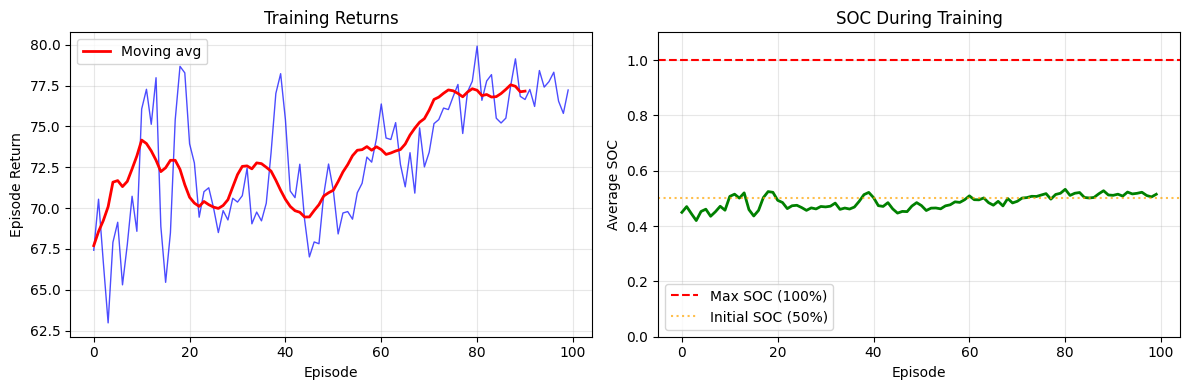

In [9]:
# Plot training progress
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(returns, 'b-', linewidth=1, alpha=0.7)
axes[0].plot(np.convolve(returns, np.ones(10)/10, mode='valid'), 'r-', linewidth=2, label='Moving avg')
axes[0].set_xlabel('Episode')
axes[0].set_ylabel('Episode Return')
axes[0].set_title('Training Returns')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(avg_socs, 'g-', linewidth=2)
axes[1].axhline(y=1.0, color='red', linestyle='--', label='Max SOC (100%)')
axes[1].axhline(y=0.5, color='orange', linestyle=':', alpha=0.7, label='Initial SOC (50%)')
axes[1].set_xlabel('Episode')
axes[1].set_ylabel('Average SOC')
axes[1].set_title('SOC During Training')
axes[1].set_ylim(0.0, 1.1)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 4: Event-Driven Testing (Mode B)

HERON provides built-in event-driven execution via:
- `env.setup_event_driven()` → registers agents with scheduler
- `env.setup_default_handlers()` → configures tick/action/message handlers
- `env.run_event_driven(t_end)` → runs simulation

Each agent's `tick()` method is called by the scheduler, which internally:
1. Gets observation via `observe()`
2. Computes action via policy or upstream message
3. Schedules action effect with `act_delay`

In [10]:
def test_event_driven(env, policies, duration=30.0):
    """Test trained policies in event-driven mode with timing jitter.
    
    **Encapsulation**: All field agent access goes through SystemAgent.
    
    Uses HERON's EventScheduler for timing with a custom tick handler because:
    - The trained policy expects normalized observations [soc, capacity/100, price]
    - Price comes from the environment (domain-specific knowledge)
    - Physics simulation is domain-specific (battery dynamics)
    
    HERON methods used:
    - EventScheduler.register_agent() - registers agents with timing config
    - EventScheduler.set_handler() - sets tick event handler
    - EventScheduler.run_until() - runs simulation
    - grid_system methods for all field agent access (encapsulation)
    """
    
    env.reset(seed=100)
    env.configure_agents_for_distributed()
    
    # HERON: Create event scheduler
    scheduler = EventScheduler(start_time=0.0)
    
    # Get field agent IDs through SystemAgent (not direct access!)
    field_agent_ids = env.grid_system.get_field_agent_ids()
    
    # HERON: Register agents with jitter configuration
    for aid in field_agent_ids:
        tick_config = TickConfig.with_jitter(
            tick_interval=1.0, obs_delay=0.05, act_delay=0.1,
            jitter_ratio=0.2, jitter_type=JitterType.GAUSSIAN, seed=hash(aid) % 1000
        )
        scheduler.register_agent(agent_id=aid, tick_config=tick_config)
    
    # Track results
    soc_history = {aid: [] for aid in policies}
    tick_times = {aid: [] for aid in policies}
    
    def on_tick(event, sched):
        """Custom tick handler - uses SystemAgent for all field agent access."""
        aid = event.agent_id
        if aid not in policies:
            return
        
        tick_times[aid].append(event.timestamp)
        
        # 1. Get observation through SystemAgent
        all_obs = env.grid_system.collect_field_observations(price=0.10)
        obs = all_obs[aid]
        observation = Observation(timestamp=event.timestamp, local={"obs": obs})
        
        # 2. Compute action using trained policy (deterministic for testing)
        action = policies[aid].forward_deterministic(observation)
        
        # 3. Apply action through SystemAgent
        env.grid_system.apply_field_actions({aid: action.c})
        
        # 4. Run physics and update through SystemAgent
        physics_results = env.grid_system.simulate_physics()
        env.grid_system.update_field_agents({aid: physics_results[aid]})
        
        # 5. Track SOC (get from SystemAgent's observation method)
        updated_obs = env.grid_system.collect_field_observations(price=0.10)
        soc_history[aid].append((event.timestamp, updated_obs[aid][0]))  # SOC is first element
    
    # HERON: Set event handler and run simulation
    scheduler.set_handler(EventType.AGENT_TICK, on_tick)
    num_events = scheduler.run_until(t_end=duration)
    
    print(f"Event-driven simulation: {num_events} events, {duration}s")
    for aid, times in tick_times.items():
        if len(times) > 1:
            intervals = np.diff(times)
            print(f"  {aid}: {len(times)} ticks, interval={np.mean(intervals):.3f}±{np.std(intervals):.3f}s")
    
    return soc_history, tick_times


print("="*50)
print("EVENT-DRIVEN TESTING")
print("="*50)
soc_history, tick_times = test_event_driven(env, policies, duration=30.0)

EVENT-DRIVEN TESTING
Event-driven simulation: 89 events, 30.0s
  battery_a1: 29 ticks, interval=1.071±0.157s
  battery_a2: 30 ticks, interval=1.003±0.138s
  battery_b1: 30 ticks, interval=1.026±0.186s


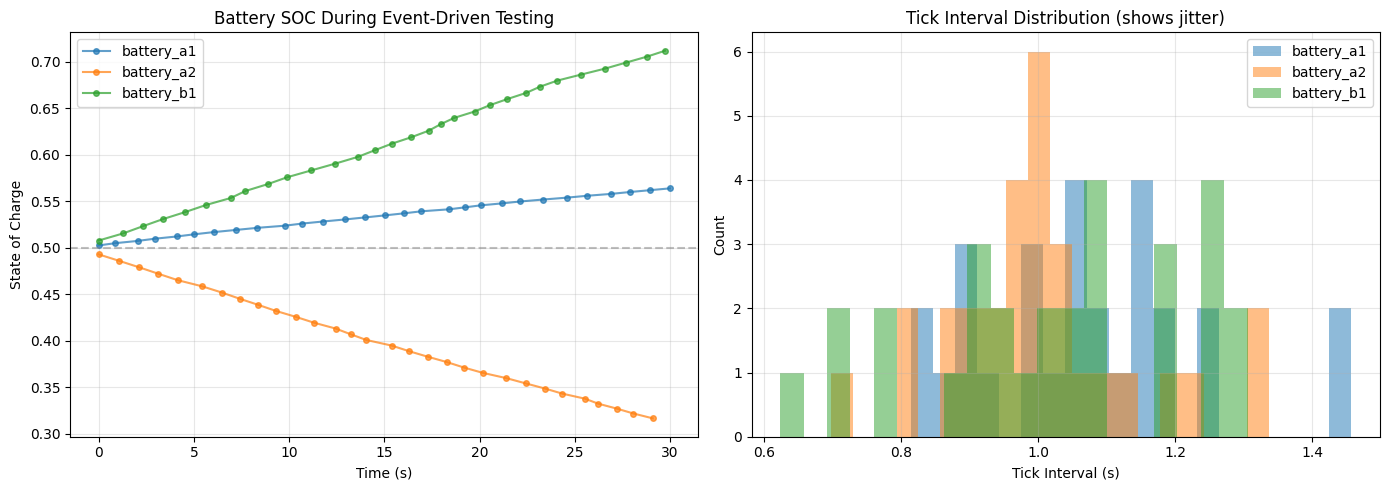


Final SOC values:
  battery_a1: 56.38%
  battery_a2: 31.67%
  battery_b1: 71.17%


In [11]:
# Plot SOC evolution during event-driven testing
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: SOC over time
ax1 = axes[0]
colors = plt.cm.tab10.colors
for i, (aid, history) in enumerate(soc_history.items()):
    if history:
        times, socs = zip(*history)
        ax1.plot(times, socs, 'o-', color=colors[i], label=aid, markersize=4, alpha=0.7)

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('State of Charge')
ax1.set_title('Battery SOC During Event-Driven Testing')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Target SOC')

# Right: Tick timing (shows jitter)
ax2 = axes[1]
for i, (aid, times) in enumerate(tick_times.items()):
    if times:
        intervals = np.diff(times)
        ax2.hist(intervals, bins=20, alpha=0.5, color=colors[i], label=aid)

ax2.set_xlabel('Tick Interval (s)')
ax2.set_ylabel('Count')
ax2.set_title('Tick Interval Distribution (shows jitter)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final SOC values
print("\nFinal SOC values:")
for aid, history in soc_history.items():
    if history:
        print(f"  {aid}: {history[-1][1]:.2%}")

---
## Part 5: Comparing Modes

Let's compare the behavior between synchronous (training) and event-driven (testing) modes.

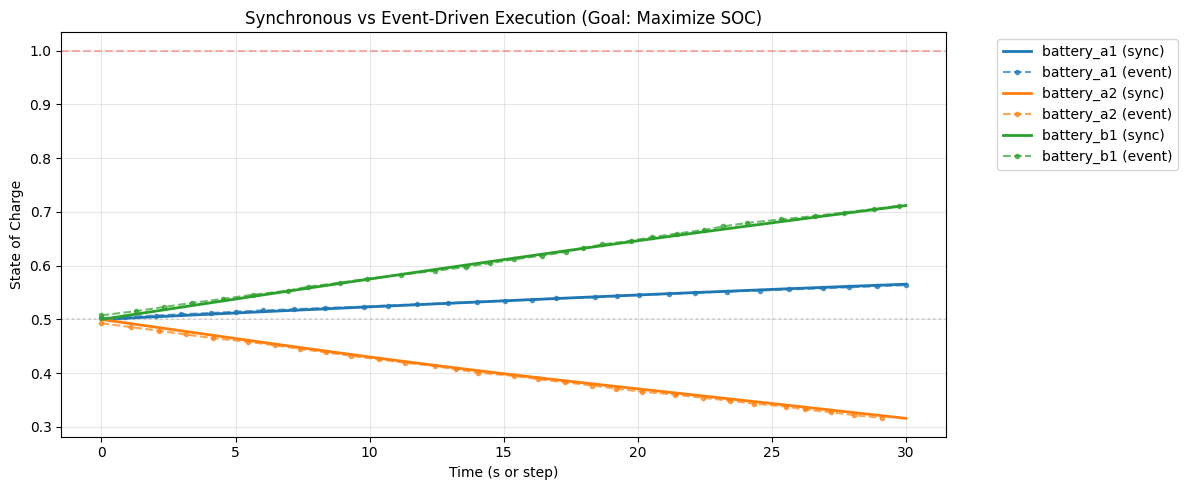


SOC comparison (sync vs event-driven):
  battery_a1: sync=56.6%, event=56.4%
  battery_a2: sync=31.6%, event=31.7%
  battery_b1: sync=71.2%, event=71.2%


In [12]:
# Run synchronous evaluation
def evaluate_sync(env, policies, num_steps=30):
    """Evaluate policies synchronously through env.step().
    
    This uses the same hierarchical control flow as training:
        env.step(actions) -> grid_system.step() -> coordinators -> field agents
    
    Uses forward_deterministic() for evaluation (no exploration noise).
    """
    obs, _ = env.reset(seed=100)
    
    # Track SOC history for each field agent
    sync_soc = {aid: [(0, 0.5)] for aid in policies.keys()}  # Start at 0.5
    
    for step in range(num_steps):
        actions = {}
        for aid, agent_obs in obs.items():
            # obs already includes price from grid_system.step()
            observation = Observation(timestamp=step, local={"obs": agent_obs})
            # Use deterministic policy for evaluation
            policy_action = policies[aid].forward_deterministic(observation)
            actions[aid] = {"c": policy_action.c}

        # env.step() handles all hierarchy: System -> Coordinator -> Field
        obs, rewards, terminated, _, info = env.step(actions)
        
        for aid, result in info["physics"].items():
            sync_soc[aid].append((step + 1, result["soc"]))
        
        if terminated["__all__"]:
            break
    
    return sync_soc

sync_soc = evaluate_sync(env, policies, num_steps=30)

# Compare synchronous vs event-driven
fig, ax = plt.subplots(figsize=(12, 5))

colors = plt.cm.tab10.colors
for i, aid in enumerate(policies.keys()):
    # Sync (solid lines)
    times_s, socs_s = zip(*sync_soc[aid])
    ax.plot(times_s, socs_s, '-', color=colors[i], label=f'{aid} (sync)', linewidth=2)
    
    # Event-driven (dotted with markers)
    if soc_history[aid]:
        times_e, socs_e = zip(*soc_history[aid])
        ax.plot(times_e, socs_e, 'o--', color=colors[i], label=f'{aid} (event)', alpha=0.7, markersize=3)

ax.set_xlabel('Time (s or step)')
ax.set_ylabel('State of Charge')
ax.set_title('Synchronous vs Event-Driven Execution (Goal: Maximize SOC)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.3, label='Max SOC')
ax.axhline(y=0.5, color='gray', linestyle=':', alpha=0.3, label='Initial SOC')
plt.tight_layout()
plt.show()

# Print comparison
print("\nSOC comparison (sync vs event-driven):")
for aid in policies.keys():
    sync_final = sync_soc[aid][-1][1]
    event_final = soc_history[aid][-1][1] if soc_history[aid] else 0.5
    print(f"  {aid}: sync={sync_final:.1%}, event={event_final:.1%}")

---
## Summary

This tutorial demonstrated:

1. **FeatureProviders** - Define observable state with visibility rules
2. **FieldAgent** - Level 1 devices (batteries)
3. **CoordinatorAgent** - Level 2 zone managers
4. **SystemAgent** - Level 3 top-level controller (only env interface)
5. **CTDE Training** - Synchronous training with centralized information
6. **Event-Driven Testing** - Asynchronous validation with realistic timing

### Key Takeaways

- **Hierarchical agents** enable scalable multi-agent systems
- **Proper encapsulation**: Environment only interacts with SystemAgent
- **CTDE** allows efficient training with joint information
- **Event-driven testing** validates robustness to timing variability
- **Same policies** work in both modes - train once, deploy anywhere

### RL Implementation Notes

**Observation normalization** is critical:
- Raw observations like `[soc, capacity, price]` = `[0.5, 100.0, 0.1]` have very different scales
- Large values (capacity=100) dominate network weights and cause random initialization issues
- Solution: Normalize to similar scales, e.g., `[soc, capacity/100, price]` = `[0.5, 1.0, 0.1]`

**Avoid return normalization** for simple positive reward tasks:
- With reward = SOC (always positive), return normalization can backfire
- Bad trajectories (discharge → SOC=0) still have "positive" advantages for early steps
- This reinforces bad behavior! Use critic baseline instead: `advantage = return - V(s)`